In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

%matplotlib inline

In [39]:
train_df = pd.read_json("train.json").reset_index(drop=True)
test_df = pd.read_json("test.json").reset_index(drop=True)
train_df['test'] = False
test_df['test'] = True

cdf = train_df.append(test_df).reset_index(drop=True)
cdf.shape

(124011, 16)

In [3]:
cdf.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,124011.000000,124011.000000,124011.000000,1.240110e+05,124011.000000,1.240110e+05
mean,1.212622,1.543460,40.737641,7.024022e+06,-73.949434,3.781324e+03
std,0.595209,1.110203,0.744337,1.263795e+05,1.372882,1.582988e+04
min,0.000000,0.000000,0.000000,6.811957e+06,-121.488000,1.000000e+00
25%,1.000000,1.000000,40.728000,6.915638e+06,-73.991700,2.495000e+03
50%,1.000000,1.000000,40.751700,7.021451e+06,-73.977800,3.150000e+03
75%,1.000000,2.000000,40.774300,7.129028e+06,-73.954700,4.100000e+03
max,112.000000,8.000000,44.883500,7.761779e+06,0.000000,4.490000e+06


Before proceeding forward:
- Clean the data
- Remove any outliers
- Perform exploratory data analysis to understand the data.

### Feature engineering
Compute additional features:

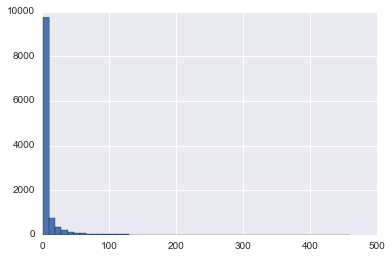

In [4]:
bldg_id_counts = cdf.building_id.value_counts()
plt.hist(bldg_id_counts[bldg_id_counts < 500], bins=50)
plt.show()

In [5]:
cdf['words_in_description'] = cdf.description.map(lambda d: len(d.split()))
cdf['listings_in_bldg'] = cdf.building_id.map(lambda b: bldg_id_counts[b] if b != '0' else 1)
cdf['num_photos'] = cdf.photos.map(len)
cdf['created'] = pd.to_datetime(cdf['created'])
cdf['created_month'] = cdf.created.map(lambda dt: dt.month)
cdf['created_day'] = cdf.created.map(lambda dt: dt.dayofweek)

In [6]:
inputs = (cdf[['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price',
               'listings_in_bldg', 'num_photos', 'created_month', 'created_day', 'words_in_description']]).copy()

targets = cdf['interest_level'].copy()

inputs.head()

,bathrooms,bedrooms,latitude,longitude,price,listings_in_bldg,num_photos,created_month,created_day,words_in_description
0,1.5,3,40.7145,-73.9425,3000,5,5,6,4,93
1,1.0,2,40.7947,-73.9667,5465,51,11,6,6,0
2,1.0,1,40.7388,-74.0018,2850,131,8,4,6,92
3,1.0,1,40.7539,-73.9677,3275,236,3,4,0,78
4,1.0,4,40.8241,-73.9493,3350,1,3,4,3,67


### One-hot encoding of categorical features

In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()
inputs['created_month'] = le.fit_transform(inputs['created_month'])

In [8]:
ohe = OneHotEncoder()
encoded = ohe.fit_transform(inputs.created_month.values.reshape(-1,1)).toarray()
encoded = pd.DataFrame(encoded, columns=['month_is_4', 'month_is_5', 'month_is_6'])
inputs = inputs.merge(encoded, left_index=True, right_index=True)

In [9]:
encoded = ohe.fit_transform(inputs.created_day.values.reshape(-1,1)).toarray()
encoded = pd.DataFrame(encoded, columns=['day_is_' + str(i) for i in range(7)])
inputs = inputs.merge(encoded, left_index=True, right_index=True)

inputs.head()

,bathrooms,bedrooms,latitude,longitude,price,listings_in_bldg,num_photos,created_month,created_day,words_in_description,month_is_4,month_is_5,month_is_6,day_is_0,day_is_1,day_is_2,day_is_3,day_is_4,day_is_5,day_is_6
0,1.5,3,40.7145,-73.9425,3000,5,5,2,4,93,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,2,40.7947,-73.9667,5465,51,11,2,6,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1,40.7388,-74.0018,2850,131,8,0,6,92,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1,40.7539,-73.9677,3275,236,3,0,0,78,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,4,40.8241,-73.9493,3350,1,3,0,3,67,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [10]:
inputs.drop(['created_month', 'created_day', 'month_is_4', 'day_is_0'], axis=1, inplace=True)
inputs.head()

,bathrooms,bedrooms,latitude,longitude,price,listings_in_bldg,num_photos,words_in_description,month_is_5,month_is_6,day_is_1,day_is_2,day_is_3,day_is_4,day_is_5,day_is_6
0,1.5,3,40.7145,-73.9425,3000,5,5,93,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,2,40.7947,-73.9667,5465,51,11,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1,40.7388,-74.0018,2850,131,8,92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1,40.7539,-73.9677,3275,236,3,78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,4,40.8241,-73.9493,3350,1,3,67,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [11]:
X = inputs.values.copy()
y = targets.values.copy()

X.shape

(124011, 16)

### Using the 'Description' column

In [33]:
from nltk.stem import PorterStemmer
import re

In [40]:
stemmer = PorterStemmer()

def process_desc(x):
    regex = re.compile('[^a-zA-Z ]')
    desc = regex.sub(' ', x).lower().split(" ") 
    desc = [stemmer.stem(l) for l in desc]
    desc = " ".join([l.strip() for l in desc])
    return desc

In [41]:
cdf['description_clean'] = cdf.description.apply(process_desc)

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

bow_transformer = CountVectorizer(stop_words='english', max_features=200)
desc_messages = bow_transformer.fit_transform(cdf.description_clean)
col_desc = ['desc_'+ i for i in bow_transformer.get_feature_names()] 
desc_df = pd.DataFrame(desc_messages.todense(), columns=col_desc)
cdf_desc = pd.concat([cdf.reset_index(), desc_df], axis=1)

In [43]:
desc_df.head()

,desc_access,desc_allow,desc_amaz,desc_amen,desc_ani,desc_apart,desc_applianc,desc_appoint,desc_area,desc_art,...,desc_villag,desc_walk,desc_wall,desc_washer,desc_water,desc_websit,desc_west,desc_window,desc_wood,desc_york
0,0,0,0,0,0,2,1,0,1,0,...,0,0,0,1,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,2,0,0,0,0,...,1,0,0,0,0,1,1,0,0,1
3,0,0,0,1,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
4,0,0,0,0,0,3,1,1,0,0,...,0,0,2,1,0,0,0,0,1,0


In [44]:
desc_df.shape

(124011, 200)

In [45]:
print(len(bow_transformer.vocabulary_))

200


In [46]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(desc_messages)
desc_tfidf = tfidf_transformer.transform(desc_messages)
print(desc_tfidf.shape)

(124011, 200)


### Split dataset into train and test

In [12]:
features_to_drop = [ 'building_id',
                     'created',
                     'description',
                     'display_address',
                     'features',
                     'manager_id',
                     'photos',
                     'street_address']
cdf.drop(features_to_drop, axis=1, inplace=True)

In [13]:
df = cdf[cdf.test == False]
tdf = cdf[cdf.test == True]

In [14]:
X = df.drop(['interest_level', 'listing_id', 'test'], axis=1).copy()
y = df.interest_level.copy()

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
y_test_onehot = pd.get_dummies(y_test)
y_test_onehot.head()

,high,low,medium
46637,0.0,1.0,0.0
7418,0.0,1.0,0.0
43886,0.0,1.0,0.0
1177,0.0,0.0,1.0
35080,1.0,0.0,0.0


In [16]:
df.shape, tdf.shape

((49352, 13), (74659, 13))

### Train the model
Using Logistic Regression Classification as an example:

In [17]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

In [18]:
reg = LogisticRegressionCV(cv=3, multi_class='multinomial', verbose=2, scoring='accuracy', max_iter=5000)
reg.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   55.8s finished


LogisticRegressionCV(Cs=10, class_weight=None, cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=5000,
           multi_class='multinomial', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring='accuracy',
           solver='lbfgs', tol=0.0001, verbose=2)

#### Evaluate the model

In [19]:
from sklearn.metrics import log_loss, accuracy_score

y_pred = reg.predict(X_test)
y_prob = pd.DataFrame(data=reg.predict_proba(X_test), columns=reg.classes_)
y_prob.reindex_axis(labels=['high', 'medium', 'low'])

print("Accuracy = ", accuracy_score(y_test, y_pred))
print("Log-loss = ", log_loss(y_test_onehot, y_prob))

Accuracy =  0.692219370525
Log-loss =  0.732464650145


### Predict target interest level

In [20]:
train_features = X_train.columns
train_features

Index(['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price',
       'words_in_description', 'listings_in_bldg', 'num_photos',
       'created_month', 'created_day'],
      dtype='object')

In [21]:
X_target = tdf[train_features].copy()
X_target.shape

(74659, 10)

In [22]:
target_prob = pd.DataFrame(data=reg.predict_proba(X_target), columns=reg.classes_)

In [23]:
target_prob.head()

,high,low,medium
0,0.082352,0.693310,0.224339
1,0.080507,0.692527,0.226967
2,0.051834,0.736826,0.211340
3,0.091817,0.594212,0.313971
4,0.030611,0.725342,0.244047


### Write results to file for submission

First check that the predictions dataframe is the right size.

In [24]:
target_prob.shape

(74659, 3)

In [25]:
target_prob.to_csv("lr_iter5000.csv", index=False)

Upload this file on the Kaggle submissions page.

### Another example: Random Forest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=1000, max_depth=18, verbose=2)
rfc.fit(X_train, y_train)

building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 44 of 1000
build

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.1min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=18, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=2, warm_start=False)

In [27]:
from sklearn.metrics import log_loss, accuracy_score

y_pred = rfc.predict(X_test)
y_prob = pd.DataFrame(data=rfc.predict_proba(X_test), columns=rfc.classes_)
y_prob.reindex_axis(labels=['high', 'medium', 'low'])

print("Accuracy = ", accuracy_score(y_test, y_pred))
print("Log-loss = ", log_loss(y_test_onehot, y_prob))

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Accuracy =  0.725381602053
Log-loss =  0.62131336991


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


### Tuning model parameters using grid-search

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

grid_search_params = dict(n_estimators=[10,100], 
                          max_depth=[None,12,15], 
                          class_weight=[None, 'balanced'])
rfc = RandomForestClassifier()
gs = GridSearchCV(estimator=rfc, param_grid=grid_search_params, n_jobs=3, verbose=10)

gs.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   13.8s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   20.3s
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:   28.4s
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   38.0s
[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed:   51.7s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'class_weight': [None, 'balanced'], 'n_estimators': [10, 100], 'max_depth': [None, 12, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [29]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    4.6s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   13.5s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   20.6s
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:   28.7s
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   38.2s
[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed:   51.4s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'class_weight': [None, 'balanced'], 'n_estimators': [10, 100], 'max_depth': [None, 12, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [30]:
print("Best params: ", gs.best_params_)
print("Best score: ", gs.best_score_)

Best params:  {'class_weight': None, 'n_estimators': 100, 'max_depth': 15}
Best score:  0.722457013837


In [32]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = gs.predict(X_test)

print(classification_report(y_test, y_pred))
classes = gs.best_estimator_.classes_
pd.DataFrame( confusion_matrix(y_test, y_pred), 
              index= ['true_'+classes[i] for i in range(len(classes))],
              columns= ['pred_'+classes[i] for i in range(len(classes))] )

             precision    recall  f1-score   support

       high       0.61      0.16      0.26      1154
        low       0.75      0.95      0.84     10257
     medium       0.47      0.21      0.29      3395

avg / total       0.68      0.72      0.67     14806



,pred_high,pred_low,pred_medium
true_high,188,592,374
true_low,42,9775,440
true_medium,79,2600,716
